In [6]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.nan)
from matplotlib.colors import ListedColormap

pdata = pd.read_csv("../Data/preprocessed_final.csv")
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})

In [2]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

#Splits the data to create X_train, y_train, X_test and y_test for the plots
def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']
X_train, X_test, y_train, y_test = get_split_data(pdata, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


In [4]:
#Standardize X components
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Apply dimensionality reduction
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Fit classifier
logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9042553191489362


Confusion matrix, without normalization
[[42  5]
 [ 4 43]]
Normalized confusion matrix
[[0.89 0.11]
 [0.09 0.91]]


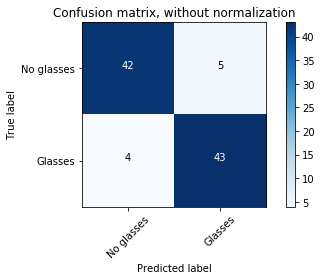

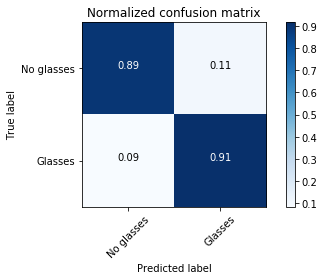

In [5]:
#Plot confusion matrix
class_names = ['No glasses', 'Glasses']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

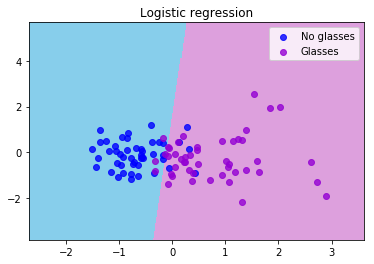

In [7]:
#Plot graph
cmap_background = ListedColormap(['skyblue', 'plum'])
#Plot the decision boundary
h = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_background)

#Plot the test points
colors = ['blue', 'darkviolet']
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

#Plot the graph    
labels = ['No glasses', 'Glasses']
plt.legend(labels)
plt.title('Logistic regression')
# plt.savefig('Logistic regression')
plt.show()

In [8]:
#Code that loops through the data 100 times and calculates the accuracy for every loop and returns the mean
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    #Standardize the x components
    scaler = StandardScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #Apply dimensionality reduction
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    #Fit the classifier
    logreg = LogisticRegression(solver = 'lbfgs')
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    return accuracy_score(y_test, y_pred)*100



make_decisions(pdata, collist)

89.36170212765957

In [9]:
#Code that prints the accuracy of varies variable combinations
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')



mad_SegmentData, mean_StepLength: 85.2 %.
mean_StepLength, std_SegmentData: 85.13 %.
GaitTime, mean_StepLength, mad_SegmentData: 86.66 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 86.16 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 85.2 %.
GaitTime, mean_StepLength, Height: 86.12 %.
GaitTime, mean_StepLength, Age: 84.69 %.
mean_StepLength, Height: 86.65 %.
mean_StepLength, Age: 84.14 %.
GaitTime, Height: 84.48 %.
std_SegmentData, Height: 72.2 %.
mad_SegmentData, Age: 71.24 %.
